In [24]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import target
import importlib
from target import calculate_target
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
importlib.reload(target)

<module 'target' from '/home/alessio/MarGui-Project/target.py'>

In [25]:
ticker = "AAPL"
predict_colum = "Close"
index_colum = "Date"
ARIMA_ORDER = (1, 1, 0) 

In [26]:
df = pd.read_csv(
    f"csv/{ticker}_indicators.csv",
    index_col=0,
    parse_dates=[0],
    date_format="ISO8601"
)

df = df.sort_index()
simulation_df = df.copy()

df['Target'] = calculate_target(df, profit_take_pct=2, stop_loss_pct=1.0)
df = df.dropna(subset=["Target"])
df['Target'] = df['Target'].astype(int)

simulation_size = int(len(df) * 0.15) + int(len(df) * 0.70)

inferred = pd.infer_freq(df.index)  # type: ignore
if inferred:
    df = df.asfreq(inferred)
else:
    df = df.asfreq('B')

# Handle missing values WITHOUT frequency inference yet
df = df.ffill().bfill()
df = df.astype(float)

# Define forecast horizon
forecast_horizon = 5

train_size = int(len(df) * 0.80)

train_data = df[:train_size].copy()
test_data = df[train_size:].copy()

print(f"\nData split (before frequency inference):")
print(f"  Train: {train_data.index[0].date()} -> {train_data.index[-1].date()} ({len(train_data)} rows)")

# Define exogenous variables (exclude Close and future targets)
exog_cols = [col for col in df.columns 
             if not col.startswith('Close') or col != 'Target'] 

print(f"\nTotal features available: {len(exog_cols)}")

# Create target variables ONLY for train and validation (not test to preserve full date range)
for i in range(1, forecast_horizon + 1):
    train_data[f'Close_t+{i}'] = train_data[predict_colum].shift(-i)

# Remove rows where we don't have future values in train/val
train_data = train_data.dropna()

# Prepare feature matrices
X_train_raw = train_data[exog_cols]
X_test_raw = test_data[exog_cols]

# Feature selection: Select top K most predictive features
k_best = 7

# Use t+1 target for feature selection (most relevant short-term)
selector = SelectKBest(f_regression, k=k_best)
selector.fit(X_train_raw, train_data['Close_t+1'])

# Get selected feature names
selected_mask = selector.get_support()
selected_features = X_train_raw.columns[selected_mask].tolist()

print(f"\nSelected {len(selected_features)} best features:")
for feat in selected_features:
    print(f"  - {feat}")

# Filter to selected features
X_train_raw = X_train_raw[selected_features]
X_test_raw = X_test_raw[selected_features]

# Scale the features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_raw),
    index=X_train_raw.index,
    columns=X_train_raw.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_raw),
    index=X_test_raw.index,
    columns=X_test_raw.columns
)


Data split (before frequency inference):
  Train: 2018-03-19 -> 2024-05-08 (1603 rows)

Total features available: 56

Selected 7 best features:
  - Adj Close
  - Close
  - High
  - Low
  - Open
  - SMA
  - EMA20


In [27]:
# Train models for each horizon on training data only
models = {}
for day_ahead in range(1, forecast_horizon + 1):
    print(f"\nTraining model for t+{day_ahead}...")
    
    y_train = train_data[f'Close_t+{day_ahead}']
    
    # Train ARIMA model
    model = ARIMA(y_train, exog=X_train_scaled, order=ARIMA_ORDER)
    fitted = model.fit()
    models[day_ahead] = fitted
    print(f"   Converged with order {ARIMA_ORDER}")

print("\nModels trained successfully on training data")


Training model for t+1...


   Converged with order (1, 1, 0)

Training model for t+2...
   Converged with order (1, 1, 0)

Training model for t+3...
   Converged with order (1, 1, 0)

Training model for t+4...
   Converged with order (1, 1, 0)

Training model for t+5...
   Converged with order (1, 1, 0)

Models trained successfully on training data


In [28]:
# Prediction function
def predict_next_5_days(models = models, scaler = scaler, current_features = X_train_raw.iloc[-1]):
    """
    Given today's features, predict next 5 days
    
    Args:
        models: dict of fitted ARIMA models
        scaler: fitted StandardScaler
        current_features: Series with feature names matching training
    
    Returns:
        array of 5 predicted closing prices
    """
    # Scale features - ensure it's a DataFrame with column names
    features_df = pd.DataFrame([current_features])
    features_scaled = scaler.transform(features_df)
    
    predictions = []
    for day_ahead in range(1, 6):
        pred = models[day_ahead].forecast(steps=1, exog=features_scaled)
        predictions.append(pred.iloc[0])  # Use .iloc[0] instead of [0]
    return np.array(predictions)


In [29]:
df = simulation_df.iloc[simulation_size:].copy()
# Standardize column names to string and strip whitespace
df.columns = df.columns.astype(str).str.strip()

# Ensure all selected_features and 'Close' are present
required_cols = set([str(col).strip() for col in selected_features] + ['Close'])
missing_cols = required_cols - set(df.columns)
if missing_cols:
    raise ValueError(f"Missing columns in test_data: {missing_cols}")

def arima(row):
    # Defensive: ensure all selected_features are present in the row
    try:
        features = row[selected_features]
    except KeyError as e:
        print(f"Missing feature in row: {e}")
        return np.nan

    # Get the 5-day predicted closing prices
    predicted_closes = predict_next_5_days(models=models, scaler=scaler, current_features=features)
    
    # Create a DataFrame that mimics the structure expected by calculate_target
    data = np.concatenate([[row['Close']], predicted_closes])
    predicted_df = pd.DataFrame({
        'Close': data,
        'High': data,
        'Low': data
    })
    
    # Calculate target on the predicted data
    target_result = calculate_target(predicted_df, profit_take_pct=2, stop_loss_pct=1.0)
    
    # Return the first valid target (since we only care about the signal from day 1)
    return target_result.iloc[0] if not target_result.empty else np.nan

# Apply the arima function to each row
df['Predicted_Target'] = df.apply(arima, axis=1)
df['Predicted_Target'] = df['Predicted_Target'].astype(int)  # Convert to integer

==========AAPL==========
Testing sul periodo che va dal 2024-09-26 a 2025-11-28
Modello: Soldi di partenza: 1000 | Soldi alla fine 1122.223079632525 | Guadagno 12.222 %


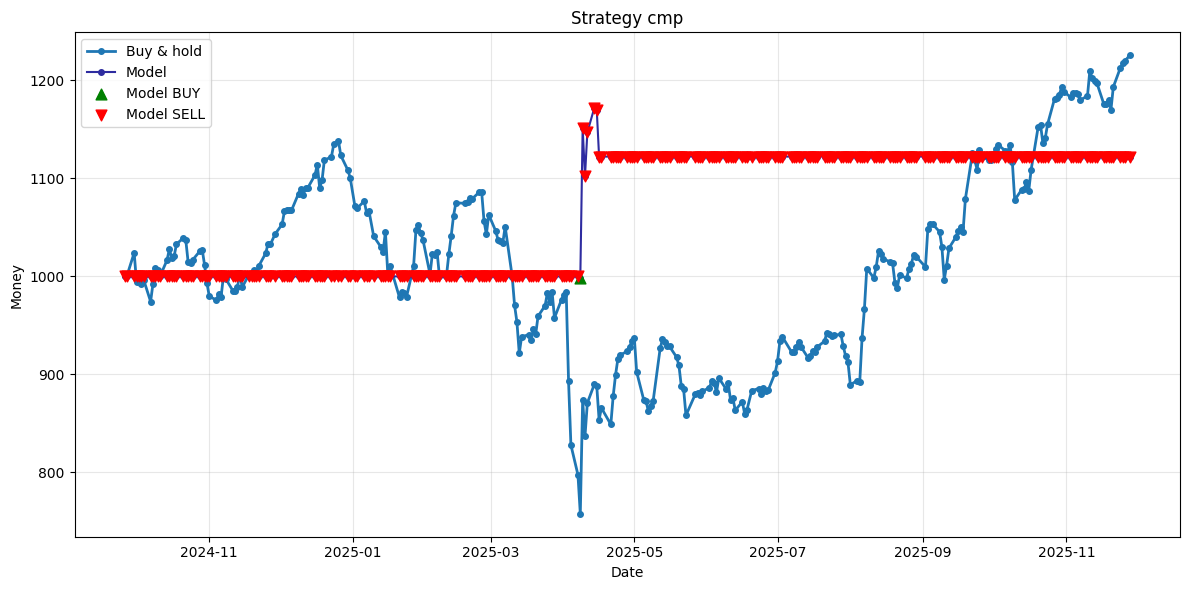

In [30]:
starting_cash = 1000
commission = 0.002

# Baseline: Buy and Hold
print("=" * 10 + f"{ticker}" + "=" * 10)

own_tikers = starting_cash / df.iloc[0]["Close"]
payout_bnh = own_tikers * df.iloc[-1]["Close"]

state = {
    "cash": starting_cash,
    "shares": 0.0,
    "streak": 0,
    "buy_price": 0,
    "max_price": 0
}

def arima_strategy(row):
    price = float(row["Close"])

    if row["Predicted_Target"] == 1:
        state["streak"] = 0
        if state["shares"] == 0:
            # Buy completo
            state["max_price"] = price
            state["buy_price"] = price
            state["shares"] += (state["cash"] * (1-commission)) / price
            state["cash"] = 0.0
            state["streak"] = 0
        
    if row["Predicted_Target"] == 0:
        state["streak"] += 1
        if state["shares"] != 0 and (state["streak"] > 5):
            # Vendita totale
            state["cash"] += state["shares"] * price * (1-commission)
            state["shares"] = 0.0
            state["streak"] = 0

    return state["cash"] + (state["shares"] * price)

# Uso la strategia sul data set
df["model_value"] = df.apply(arima_strategy, axis=1)

# Final payout
final_price = float(df.iloc[-1]["Close"])
payout_arima = state["cash"] + (state["shares"] * final_price)

print(f"Testing sul periodo che va dal {df.index[0].date()} a {df.index[-1].date()}")
print(f"Modello: Soldi di partenza: {starting_cash} | Soldi alla fine {payout_arima} | Guadagno {((payout_arima - starting_cash)/starting_cash) * 100:.3f} %")

plt.figure(figsize=(12,6))

idx = df.index
bh_series = df["Close"] * own_tikers
model_series = df["model_value"]

plt.plot(idx, bh_series, label='Buy & hold', color='#1f77b4', linewidth=2, marker='o', markersize=4)
plt.plot(idx, model_series, label='Model', color="#2e2ca0", linewidth=1.5, marker='o', markersize=4)

# Show EVERY model action (aligned with model_state data)
buys = df["Predicted_Target"] == 1
sells = df["Predicted_Target"] == 0

buy_indices = df.loc[buys].index
buy_values = df.loc[buys, "model_value"]

sell_indices = df.loc[sells].index
sell_values = df.loc[sells, "model_value"]

plt.scatter(buy_indices, buy_values, marker="^", color="green", s=60, label="Model BUY", zorder=5)
plt.scatter(sell_indices, sell_values, marker="v", color="red", s=60, label="Model SELL", zorder=5)

plt.title("Strategy cmp")
plt.xlabel("Date")
plt.ylabel("Money")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


--- CONFUSION MATRIX (ARIMA Target vs Predicted) ---
              precision    recall  f1-score   support

           1       1.00      0.01      0.02       120
           0       0.59      1.00      0.74       170

    accuracy                           0.59       290
   macro avg       0.79      0.50      0.38       290
weighted avg       0.76      0.59      0.44       290



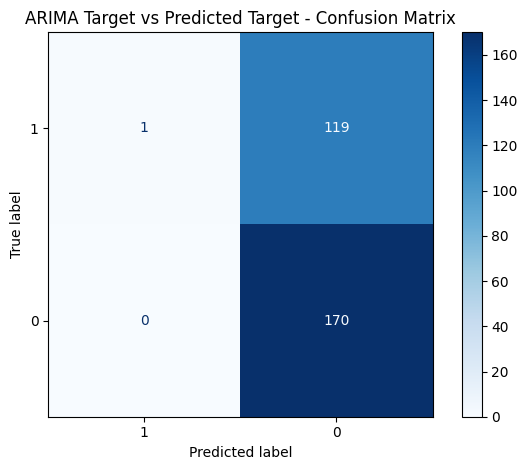

In [31]:
df['Target'] = calculate_target(df, profit_take_pct=2, stop_loss_pct=1.0)
#print(df.index)
df = df.dropna(subset=["Target"])
df['Target'] = df['Target'].astype(int)

print("\n--- CONFUSION MATRIX (ARIMA Target vs Predicted) ---")
print(classification_report(df["Target"], df["Predicted_Target"], labels=[1, 0]))

cm = confusion_matrix(df["Target"], df["Predicted_Target"], labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
disp.plot(cmap="Blues")
plt.title('ARIMA Target vs Predicted Target - Confusion Matrix')
plt.tight_layout()
plt.show()

In [32]:
# Debug: inspect date ranges through pipeline
print("=== Debug: Date Ranges ===")
print("Raw df last date:", pd.read_csv(
    f"csv/{ticker}_indicators.csv", index_col=0, parse_dates=[0], date_format="ISO8601"
).sort_index().index.max())

print("Train last date:", train_data.index.max())
print("Test last date (before target/dropna):", test_data.index.max())

tmp_df = test_data.copy()
tmp_df['Target'] = calculate_target(tmp_df, profit_take_pct=2, stop_loss_pct=1.0)
print("Test last date after target add:", tmp_df.index.max())
tmp_df2 = tmp_df.dropna(subset=["Target"])
print("Test last date after dropna(Target):", tmp_df2.index.max())
print("Length shrink from", len(tmp_df), "to", len(tmp_df2))

# Also check predicted series alignment
print("Predicted_Target non-null count:", tmp_df2['Target'].notna().sum())


=== Debug: Date Ranges ===
Raw df last date: 2025-11-28 00:00:00
Train last date: 2024-05-01 00:00:00
Test last date (before target/dropna): 2025-11-20 00:00:00
Test last date after target add: 2025-11-20 00:00:00
Test last date after dropna(Target): 2025-11-13 00:00:00
Length shrink from 401 to 396
Predicted_Target non-null count: 396
